# Read me
This template is meant to be a starter for your customized DREEM output data analysis.

- To install this library, please check the installation on the [Git repo](https://github.com/yvesmartindestaillades/NAP).
- To learn how to use this library, please get through the [tutorial](tutorial.ipynb).


# Turner overthrown

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from os.path import exists, dirname
import os, sys
import string
import seaborn as sns
sys.path.append(os.path.abspath(".."))
from nap import data_wrangler, firebase, plot, utils

try:
    sys.path.append(dirname('libs/dreem/dreem')) 
except:
    "If dreem isn't installed on your computer, the code won't run"
    

# Step 1: Data wrangling
### Step 1.1: Define your study and some basics about your project

In [ ]:
# Set your username for the database (at the moment, keep Yves)
username = 'Yves'

# Select your study
study = 'temperature' 

## Set your base coverage high-pass filter value
min_bases_cov = 1000 

# Set the resolution for the plots
mpl.rcParams['figure.dpi'] = 200 # the highest the resolution, the slowest the plotting
plt.rcParams["figure.figsize"] = [25, 7]
#plt.rcParams["figure.autolayout"] = True


# Depending on the study you select, you'll get a series of tubes. You can also create new studies using this dictionary.
# Here's an example.
tubes_per_study = {   
    'replicates':           ['C5', 'A4', 'F4', 'A6', 'A7'],
    'salt':                 ['A6', 'B6', 'C6', 'D6', 'E6'], 
    'temperature':          ['D7', 'E7', 'F7', 'G7', 'H7', 'A8', 'B8', 'C8'], 
    'magnesium':            ['F6', 'G6', 'H6', 'A7', 'B7', 'C7'],
    '60 mM DMS kinestics':  ['D8', 'E8', 'F8', 'G8', 'H8', 'A9'],
    'all_tubes': [ele for ele in [f"{a}{b}" for a in string.ascii_uppercase[0:8] for b in range(1,11)] \
                 if ele not in ['C3','C10','D10','E10','F10','G10','H10', 'E4']]
                 + ['C5_realignment_v3']
    }

conditions_per_study = {
    'temperature': {
        'unit':'C',
        'values':[5, 10, 25, 45, 55, 65, 75, 90]
    },
    '60 mM DMS kinestics': {
        'unit':'min',
        'values':[1, 3, 9, 27, 81]
    }
} 

# Define what you will analyse
conditions = conditions_per_study[study]
tubes = tubes_per_study[study]

### Step 1.2: Process new pickle files and push them to Firebase
- Select which tubes you want to push to Firebase.
To plot automatically arrays of tubes, see [tutorial](tutorial.ipynb), section 3.2.
- Process tubes and push them to Firebase.

In [ ]:
## Pickle files to process and to push to Firebase
pickles_list = [] # Can be tubes if you want to process the tubes from your study

pickles = data_wrangler.generate_pickles(path_to_data='data/FULLSET',
                                         pickles_list=pickles_list)

# Indicate the location of your RNA structure file
RNAstructureFile = 'data/RNAstructureFile.csv'

# Default location for your local database (JSON file)
json_file = 'data/db.json'


# If the user gives some new pickles files, push them to the firebase, then pull the entire firebase
if len(pickles):
    firebase.push_pickles(pickles = pickles,
                        RNAstructureFile = RNAstructureFile,
                        min_bases_cov = min_bases_cov, 
                        username=username)

### Step 1.3: Pull the data from the Firebase and clean/reformat it.
`df` is used for the analysis. Each of the construct have above 1000 reads for each tube.     
`df_full` is used for quality quality analysis. It has all constructs above 1000 valid reads for each tube individually.

In [ ]:
# Pull the firebase
df_rough = firebase.load(tubes=tubes, username=username)

# Clean and reformat the dataset
df, df_full = data_wrangler.clean_dataset(df_rough=df_rough,
                                             tubes=tubes, 
                                             min_bases_cov=min_bases_cov)

# Step 2: Data quality analysis

It's always hard to realize that you were analysing noise. Here, we'll get through a series a plot to check the data sanity.

### Get the list of tubes and constructs:

In [ ]:
print(f"tubes are: {tubes}")
print(f"constructs are: {df.construct.unique()}")

### Explore the data
`get_roi_info(df=df, tube=tube, construct=construct)` gives information about the Region of Interest (ROI) of a (tube, construct) pair.

In [ ]:
tube, construct = utils.rand_tube_construct(df)
utils.get_roi_info(df=df, tube=tube, construct=construct).xs((True, '0'),level=('paired','roi_structure_comparison'))   

### (tube, construct)-specific base coverage plot

In [ ]:
tube, construct = utils.rand_tube_construct(df)
plot.base_coverage(df, tube, construct , min_bases_cov=min_bases_cov)

### Plot the base coverage per construct distribution

In [ ]:
plot.base_coverage_for_all_constructs(df=df_full, 
                                      min_bases_cov=min_bases_cov)

### Sanity-check construct-wise base coverage plots
Plot randomly picked sequences to check the quality of the data.

In [ ]:
plot.random_9_base_coverage(df=df, 
                            min_bases_cov=min_bases_cov)

### Heatmap of the roi part coverage

In [ ]:
plot.heatmap(df = df, 
             column="cov_bases_roi")

### Heatmap of the second half coverage

In [ ]:
plot.heatmap(df = df, 
                column="cov_bases_sec_half")

# Step 3: Data analysis
In this part, we know that we read good data, and we want to visualize it through different plots.

### Analysis parameters

In [ ]:
# Display the plots on this notebook? Not recommended if numerous plots
show_plots = True

# Constructs used
a_few_constructs = df.construct.unique()[:3].tolist()
first_construct = df.construct.unique()[0].tolist()
constructs_per_name = {
    'all_constructs': df.construct.unique().tolist(),
    str(a_few_constructs) : a_few_constructs,
    str(first_construct): [first_construct]
}

# Select constructs here
constructs_name = str(a_few_constructs)

# Define what you will analyse
constructs = constructs_per_name[constructs_name]

### Big script to run every selected function

In [ ]:
# Analysis run in this script
analysis = {'base_per_base_partition':False,
            'base_per_base_sequence': True,
            'deltaG': True,
            'tube_comparison':False,
            'columns_csv': True,
            'deltaG_construct': True
            }

# Write here a script to get your plots 

### Mutation sequence-wise

`plot.mutation_rate(df, tube, construct, plot_type, index, normalize)` plots the mutation rate base-wise for a given construct of a given tube as a barplot. 
Arguments:
- `plot_type` :
    - `'sequence'` : each bar is colored w.r.t to the base of the original sequence.
    - `'partition'` : each bar shows the partition of into which bases this base mutates.
- `index`:
    - `'index'`: each base is identified with its position number
    - `'base'`: each base is identified with its type (A, C, G, T)

In [ ]:
for construct in constructs:
    for tube in tubes:
        plot.mutation_rate(df=df,
                           tube=tube,
                           construct=construct,
                           plot_type='sequence',
                           index='index')
        plot.save_fig(path=f"data/figs/date/{study}/mut_per_base/sequence/{construct}/", 
                    title=f"base_per_base_sequence_{tube}_{construct}")
        plt.close(not show_plots)

### DeltaG plots

In [ ]:
for tube in tubes:
    plot.deltaG(df=df, tube=tube)

    plot.save_fig(path=f"data/figs/date/{study}/deltaG/", 
             title=f"deltaG_{tube}")

    plt.close(not show_plots)

### Tubes correlation

In [22]:
for construct in [constructs[0]]:
        df_global_corr = plot.correlation_n_tubes(df, tubes, construct)
        plot.save_fig(path=f"data/figs/date/correlation/{study}", 
                      title=f"correlation_{study}_{construct}")
        plt.title(f"Study: {study}")
        plt.close(not show_plots)
        print(construct, end=' ')

IndexError: invalid index to scalar variable.


KeyboardInterrupt



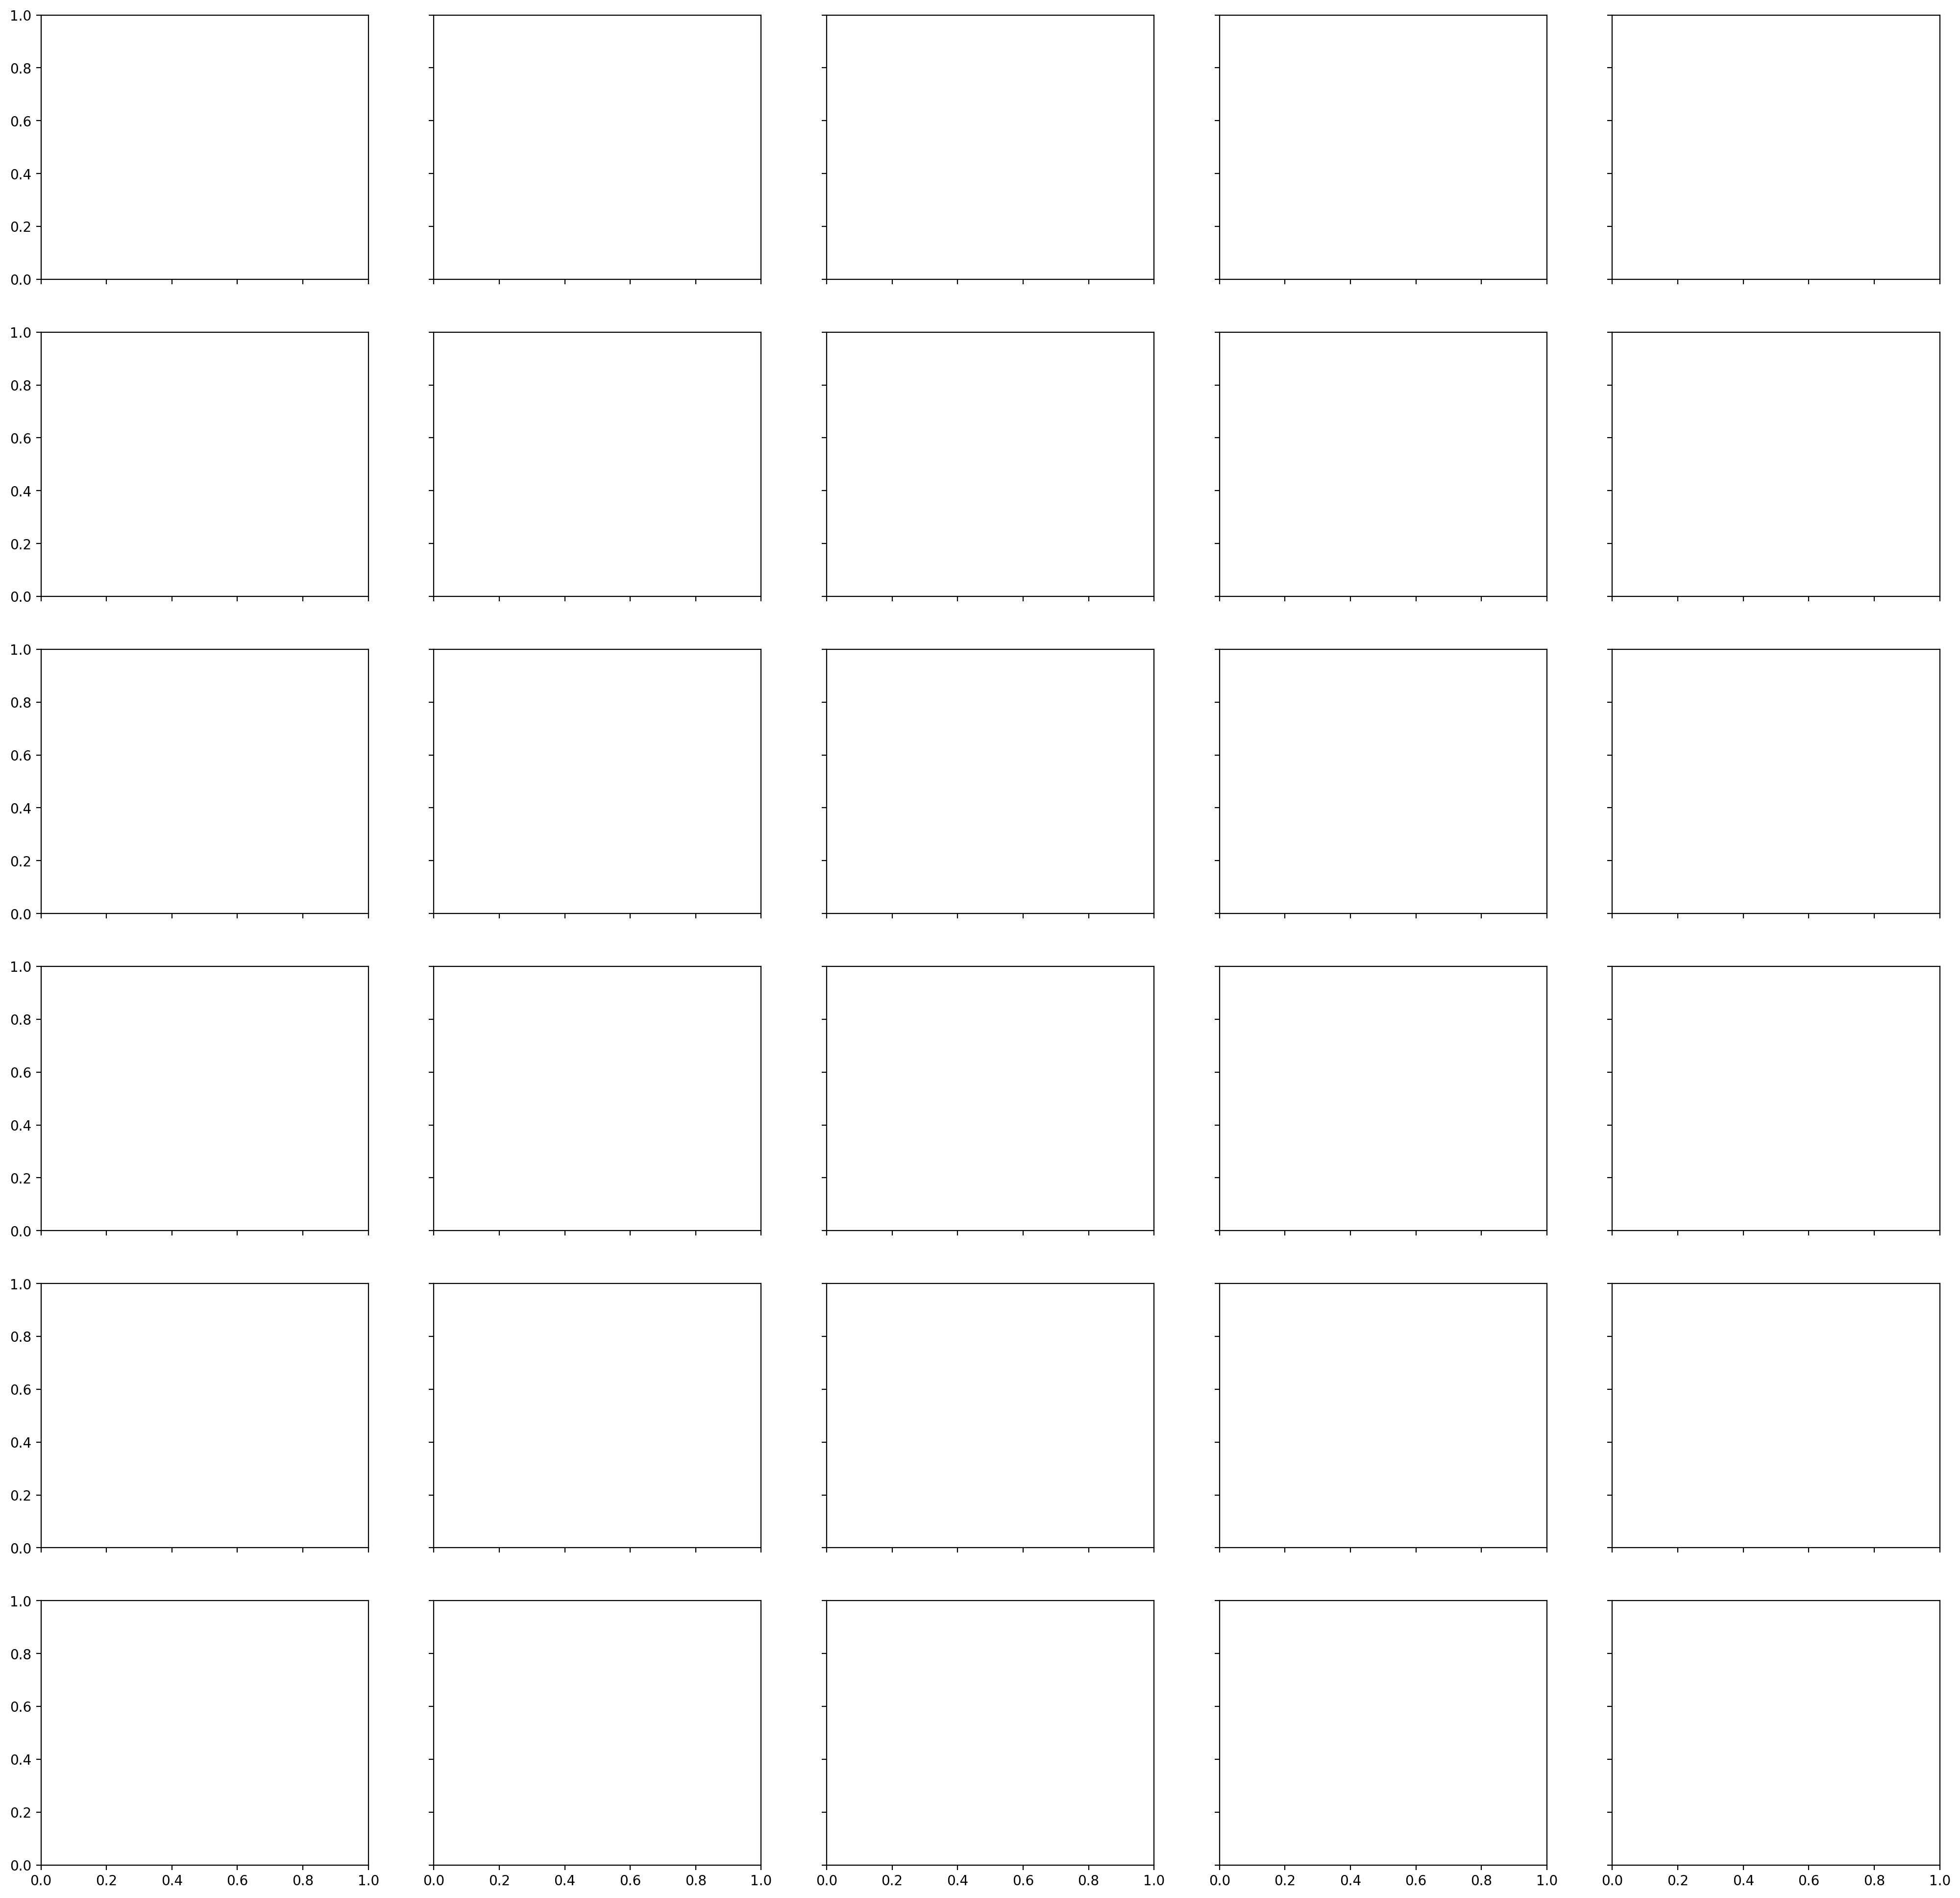

In [19]:
show_plots = False
for study in tubes_per_study:
    tubes = tubes_per_study[study]
    for constructs in df.construct.unique():
        constructs_name = constructs
        df_global_corr = plot.correlation_n_tubes(df, tubes, constructs)
        plt.title(f"Correlation between tubes for study: {study}, constructs: {constructs_name}")
        plot.save_fig(path=f"data/figs/date/correlation/{study}/{constructs_name}", 
                        title=f"correlation_fit_{study}_{constructs_name}")
        plt.close(not show_plots)

        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("tube_0","tube_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
            plt.title(f"{plt_type} of the correlation between tubes for study: {study}, constructs: {constructs_name}")
            plot.save_fig(path=f"data/figs/date/correlation/{study}/{constructs_name}", 
                            title=f"correlation_{plt_type}_{study}_{constructs_name}")
            plt.close(not show_plots)

### Heat Map

In [ ]:
#pivot = df_global_corr.pivot("tube_0","tube_1", 'r_value').astype(float)
df_global_corr

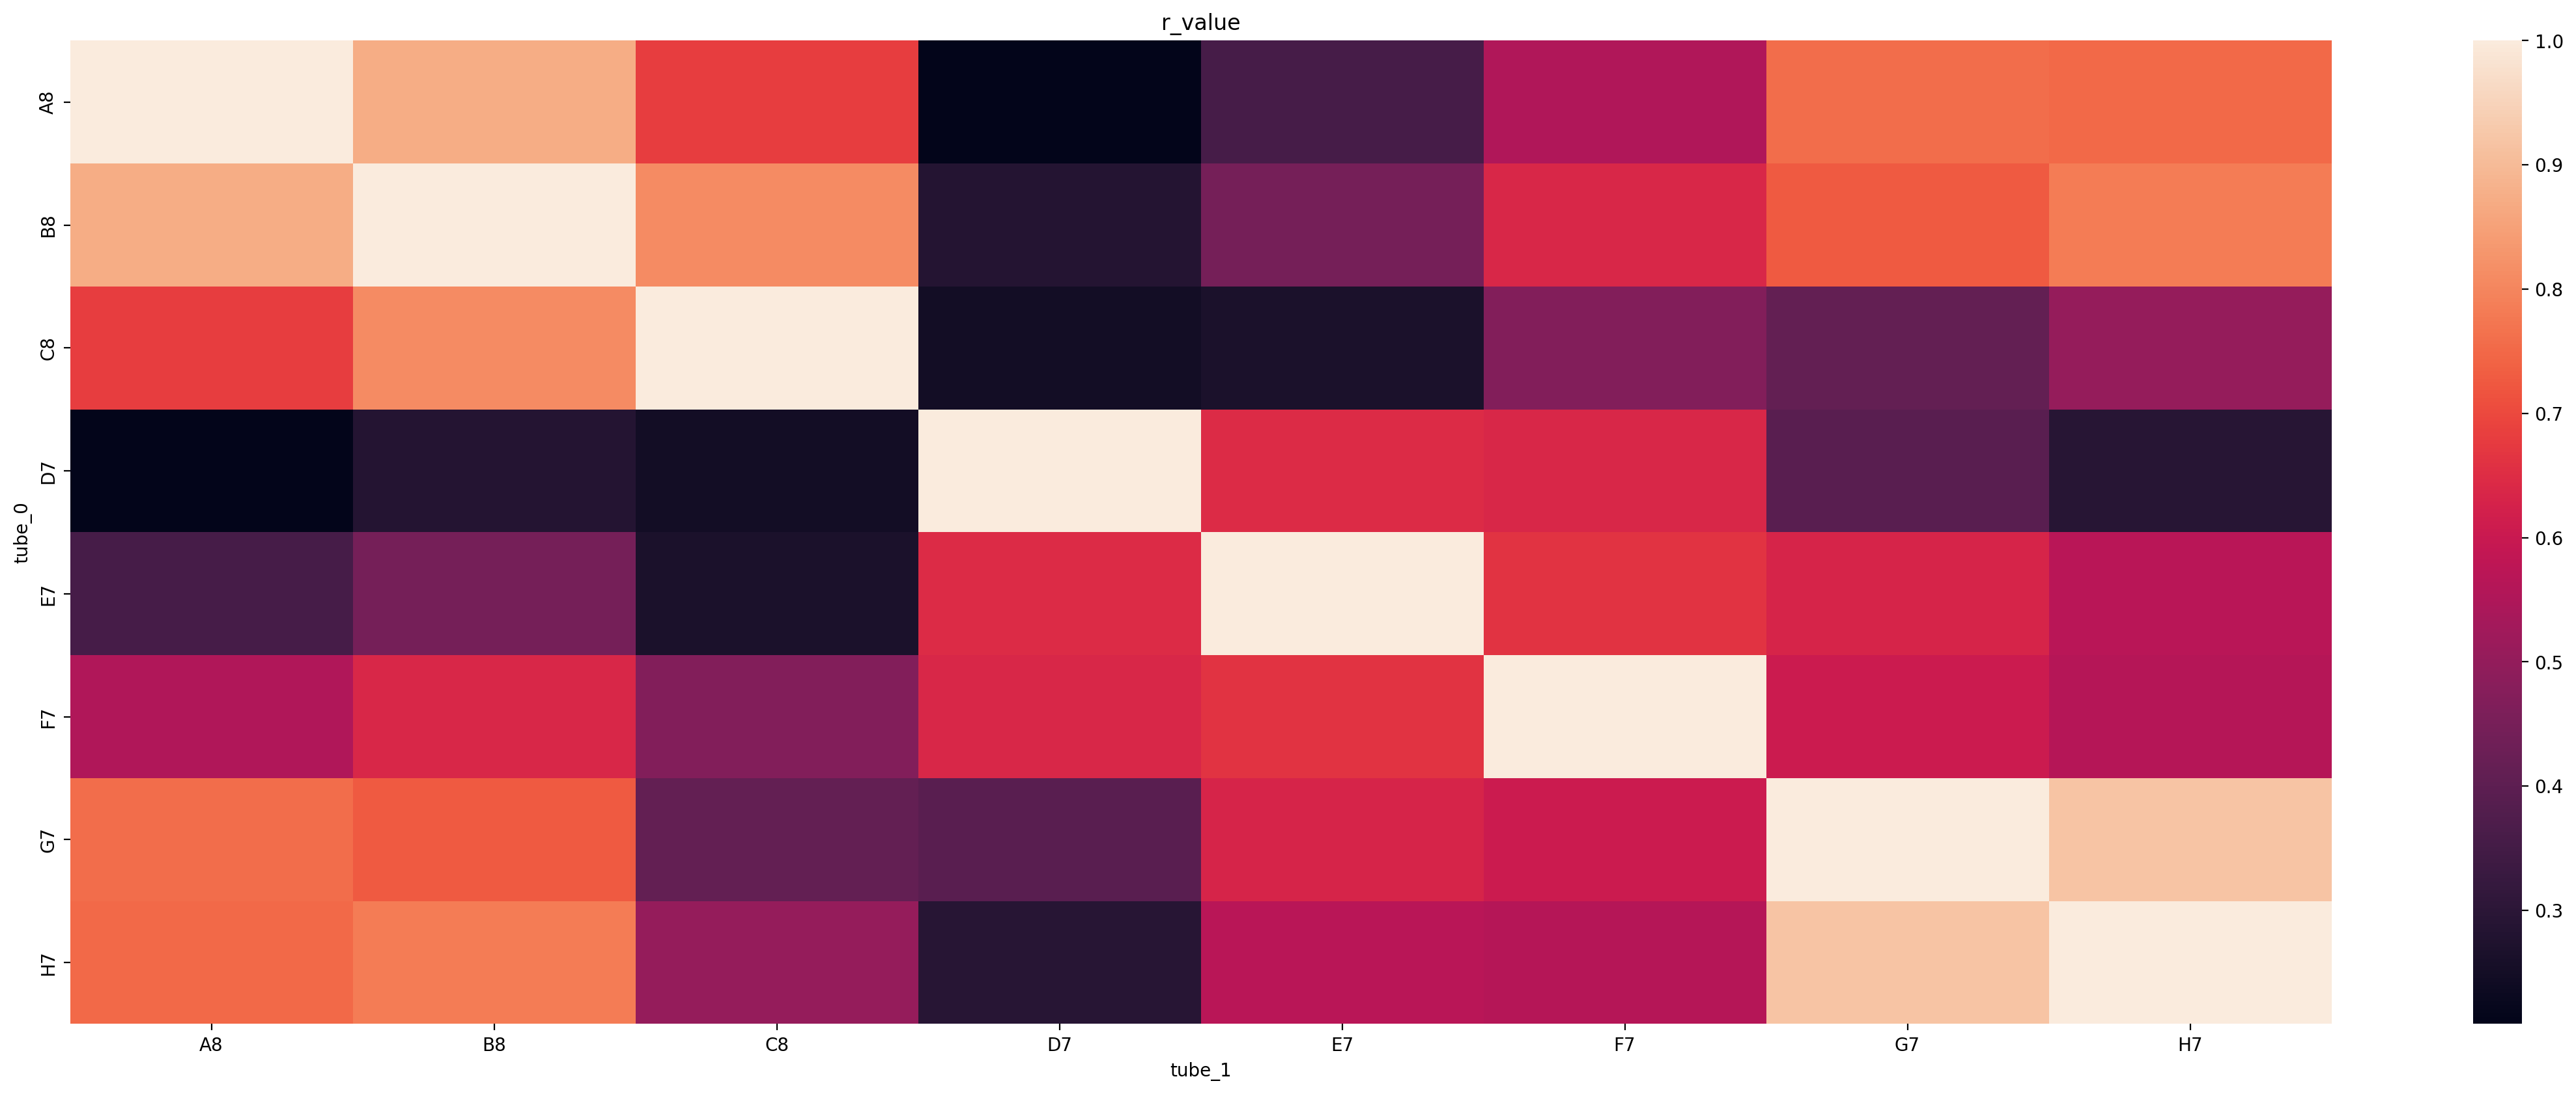

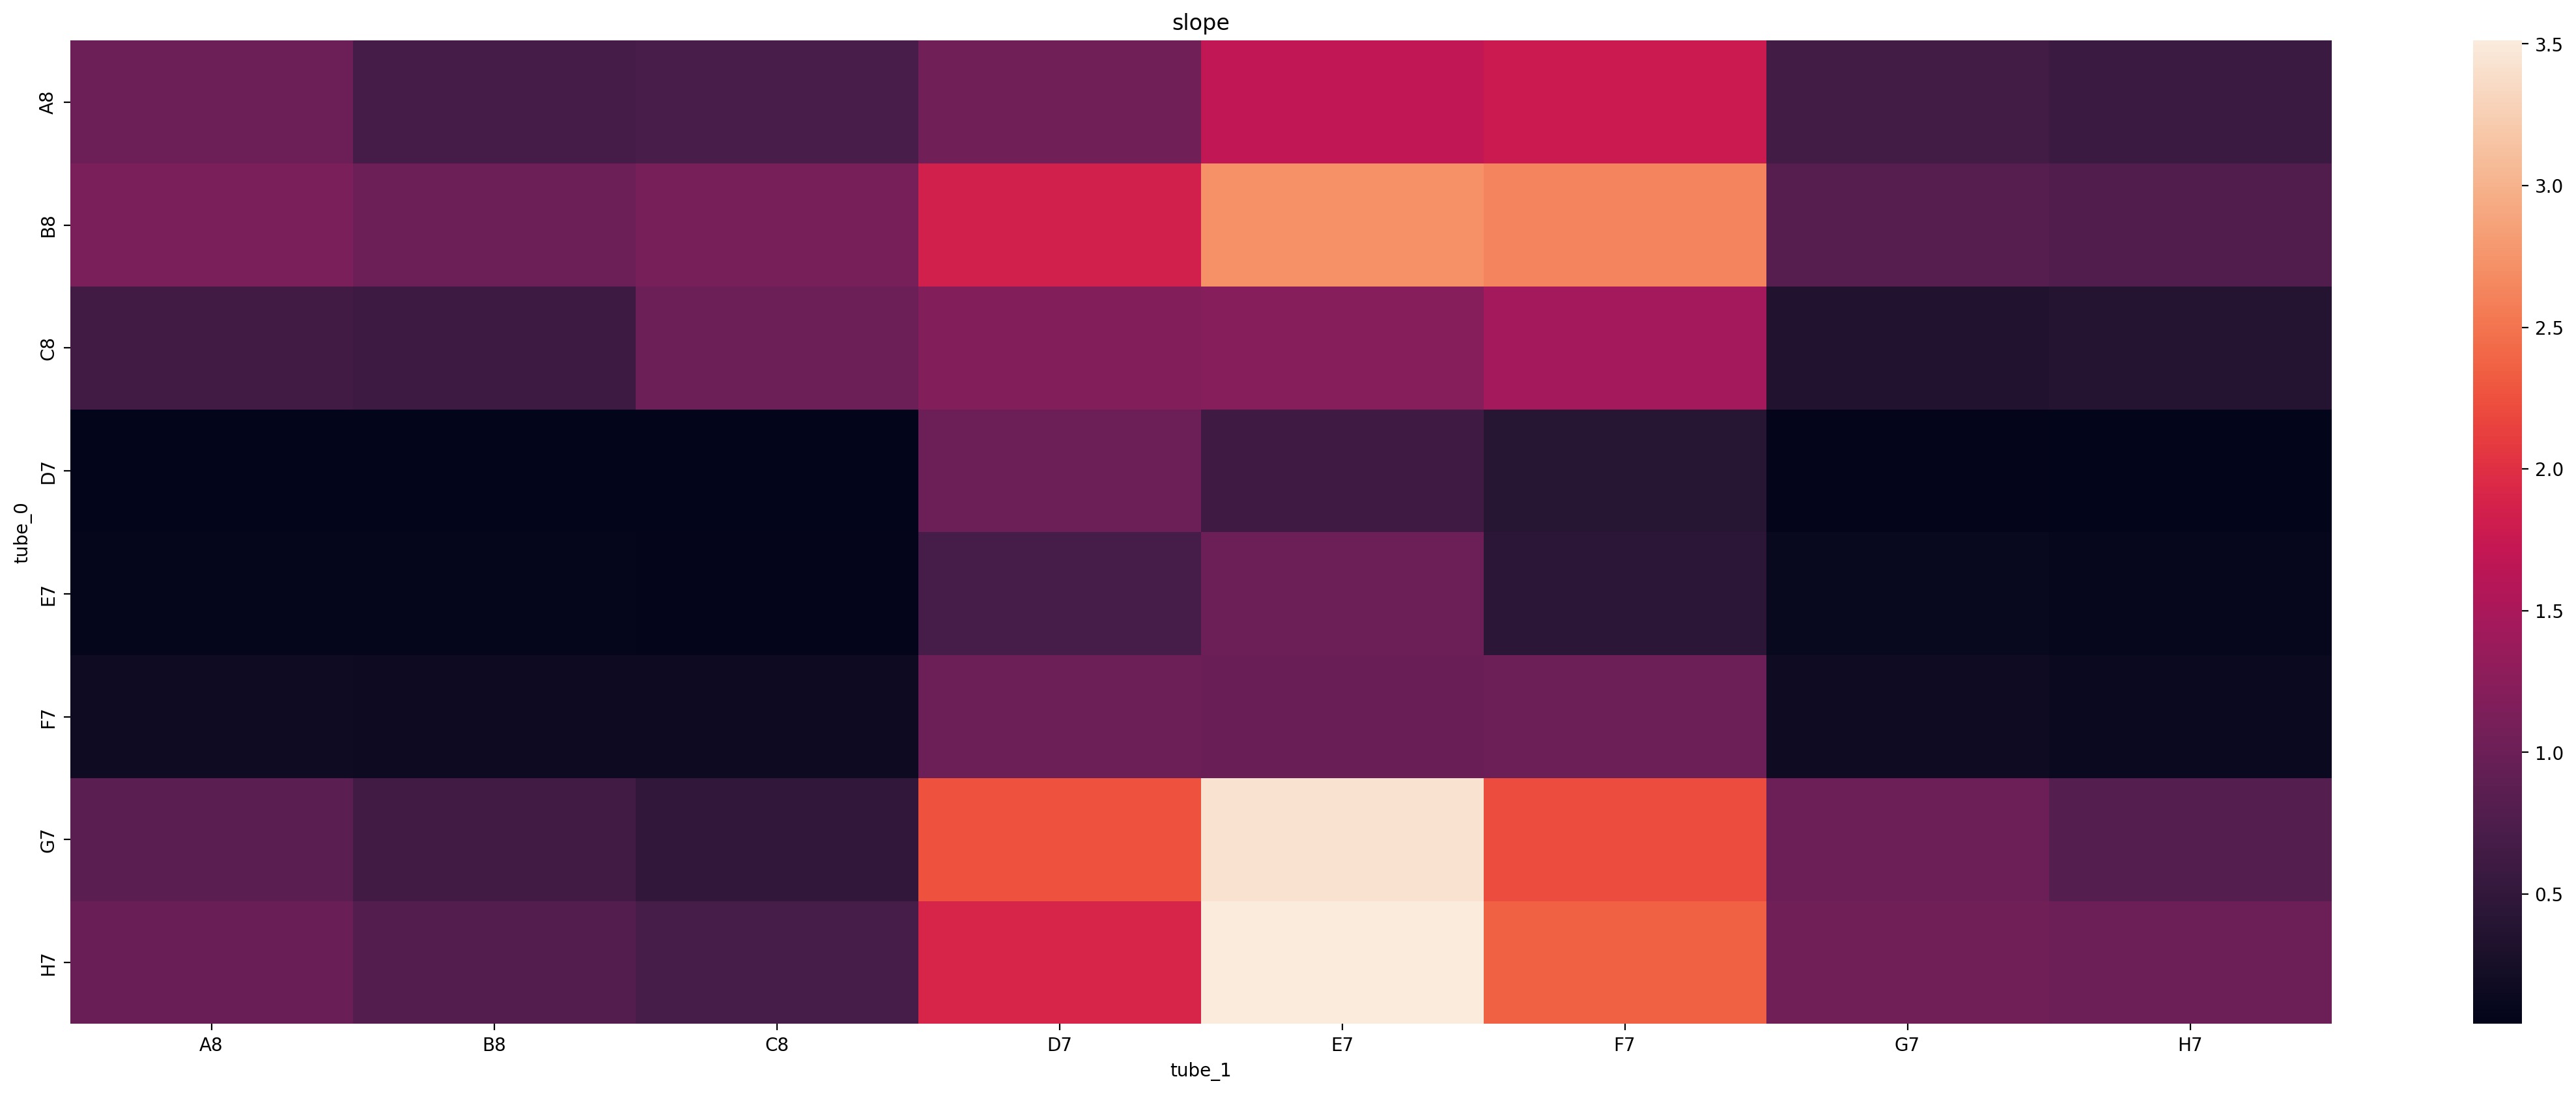

In [21]:
for plt_type in ['r_value', 'slope']:
    pivot = df_global_corr.pivot("tube_0","tube_1", plt_type).astype(float)
    f, ax = plt.subplots(figsize=(28, 10))
    sns.heatmap(pivot, annot=False, linewidths=0, ax=ax)#, norm=LinNorm())
    plt.title(plt_type)
    plot.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                    title=f"correlation_{plt_type}_{study}_all_constructs")
   # plt.close(not show_plots)

### Global correlation plot

In [ ]:
heat_map = True

for study in tubes_per_study:
   # tubes = tubes_per_study[study]

    df_global_corr = plot.correlation_n_tubes(df, tubes, constructs)
    plot.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                    title=f"correlation_{study}_all_constructs")
    plt.close(not show_plots)

    if heat_map:
        for plt_type in ['r_value', 'slope']:
            pivot = df_global_corr.pivot("tube_0","tube_1", plt_type).astype(float)
            f, ax = plt.subplots(figsize=(28, 10))
            sns.heatmap(pivot, annot=False, linewidths=0, ax=ax, norm=LogNorm())
            plot.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                            title=f"correlation_{plt_type}_{study}_all_constructs")
            plt.close(not show_plots)

In [ ]:
show_plots = 1
for study in tubes_per_study:
    if study == 'all_tubes': continue
    plot.correlation_n_tubes(df, tubes_per_study[study], constructs)
    plot.save_fig(path=f"data/figs/date/global_correlation/{study}", 
                title=f"correlation_{study}_all_constructs")
    plt.close(not show_plots)

 ### Conditions vs mutations #TODO

In [ ]:
def conditions_vs_mutations(df, tubes, study, ):
    df_use = df.set_index(['tube','construct'])

    fig = plot.define_figure(title=tube,
                            xlabel='deltaG [kcal]',
                            ylabel='Mutation ratio',
                            figsize=(20,5))

    stack_for_plot = {'0':{'x':[],'y':[]},'1':{'x':[],'y':[]}}

    for construct in df.construct.unique():
        roi_part = utils.get_roi_info(df=df, tube=tube, construct=construct)
        for base in ['A','C']:
            for roi_struct_comp in ['0','1']:
                try:    
                    this_base_mut =  roi_part.xs((base,True,roi_struct_comp), level=('base','paired','roi_structure_comparison'))
                    stack_for_plot[roi_struct_comp]['x'].extend(this_base_mut['roi_deltaG'].to_list())
                    stack_for_plot[roi_struct_comp]['y'].extend(this_base_mut['mut_rate'].to_list())
                except:
                    continue
    plt.plot(stack_for_plot['0']['x'],stack_for_plot['0']['y'],'b.')
    plt.plot(stack_for_plot['1']['x'],stack_for_plot['1']['y'],'r.')
    plot.fit_deltaG(df_use, tube)
    plt.legend(['A and C bases of the ROI, predicted paired by RNAstructure for both the ROI sequence and the full sequence',\
                'A and C bases of the ROI part, predicted paired by RNAstructure for the full sequence but not for the ROI sequence'])
    plt.ylim([0,0.15])
    fig.tight_layout()

### Save columns to a csv file

In [ ]:
utils.columns_to_csv(df=df,
                   tubes=tubes,
                   columns=['tube', 'construct','full_sequence','roi_sequence','mut_bases','info_bases'],
                   title=f"seq_and_reactivity_{study}",
                   path='data/figs/date/{study}')

### Save construct vs deltaG 

In [ ]:
utils.deltaG_vs_construct_to_csv(df=df,    
                                 title=f"deltaG_vs_construct.csv", 
                                 path = f"data/figs/date/{study}", 
                                 tubes=tubes)